# Stommel-Munk model
**23 April 2021 by MiniUFO**

---

[TOC]

---

## 1. Introduction
The classical wind-driven ocean circulation models are the Stommel-Munk model ([**Stommel 1948**](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202); [**Munk 1950**](https://journals.ametsoc.org/view/journals/atsc/7/2/1520-0469_1950_007_0080_otwdoc_2_0_co_2.xml)).  The model is about the horizontal streamfunction $\psi$ of the surface ocean circulation in response to wind-stress curl $\hat\nabla \cdot \mathbf\tau$ [here $\hat\nabla\equiv(-\partial_y, \partial_x)$], which can be written as:

$$
\begin{align}
A_4\nabla^4\psi - A_2\nabla^2\psi - \beta\frac{\partial\psi}{\partial x} = - \frac{\hat\nabla \cdot \mathbf\tau}{\rho_0D} \tag{1}
\end{align}
$$

If $A_4=0$ and $A_2\neq 0$, then Eq. (1) reduces to the Stommel (1948) model, which is a second-order partial differential equation about $\psi$; If $A_2=0$ and $A_4\neq 0$, Eq. (1) reduces to the Munk (1950) model, which is the fourth-order partial differential equation.  Therefore, Eq. (1) is also called Stommel-Munk model.  Given the wind-stress curl $\hat\nabla \cdot \mathbf\tau$, or the wind stress $\tau$ itself, one can invert the horizonal streamfunction using the SOR iteration.


## 2. Theory
Here the derivation of the Stommel-Munk model is briefly reviewed.  The start point is the horizontal momentum equation in vector form:

$$
\begin{align}
\frac{\partial \mathbf{u}}{\partial t}=-(\mathbf{u}\cdot\nabla)\mathbf{u}-\frac{1}{\rho}\nabla p+f\mathbf{\hat u}+\frac{\partial \mathbf{T}}{\partial z}+A_4\nabla^2 \mathbf{u}\tag{2}
\end{align}
$$

where $\mathbf{T}$ is the stress.  Introducing the $\hat\cdot$ operator as a counter-clockwise rotation of a 2D vector [e.g., if $\mathbf A=(A_x, A_y)$, then $\mathbf{\hat A}=(-A_y, A_x)$].  Taking the curl $\hat\nabla\cdot()$ of both sides of Eq. (2) gives the vorticity ($\hat\nabla\cdot\mathbf u=\zeta$) equation:

$$
\begin{align}
\frac{\partial \zeta}{\partial t}=-\mathbf{u}\cdot\nabla\zeta-\zeta\nabla\cdot \mathbf{u}+\hat\nabla\cdot (f\mathbf{\hat u})+\frac{\partial }{\partial z}(\hat\nabla\cdot \mathbf{T})+A_4\nabla^2 \zeta\tag{3}
\end{align}
$$

Assuming steady-state (drop first term), linear (drop second term), and nondivergent (drop the third term), one has:

$$
\begin{align}
A_4\nabla^2 \zeta+\hat\nabla\cdot (f\mathbf{\hat u})+\frac{\partial }{\partial z}(\hat\nabla\cdot \mathbf{T})=0 \tag{4}
\end{align}
$$

Assume that flow is vertically uniform within the mixed layer, and that at the surface $\mathbf{T}\vert_{sfc}=\mathbf{\tau}/\rho_0$ and at the bottom of the mixed layer $\mathbf{T}\vert_{btm}=R\mathbf{u}$ (linear drag or Newtonian cooling), Eq. (4) becomes:

$$
\begin{align}
A_4\nabla^2 \zeta+\hat\nabla\cdot (f\mathbf{\hat u})+\frac{(\hat\nabla\cdot \mathbf{\tau}/\rho_0-R\zeta)}{D}=0 \tag{5}
\end{align}
$$

After some arrangements, and introducing the streamfunction $\zeta=\nabla^2\psi$, it becomes the Stommel-Munk model:

$$
\begin{align}
A_4\nabla^4 \psi-\frac{R}{D}\nabla^2\psi-\beta\frac{\partial \psi}{\partial x}=-\frac{\hat\nabla\cdot \mathbf{\tau}}{\rho_0D}\tag{6}
\end{align}
$$

or equivalently:

$$
\begin{align}
A_4\nabla^4 \psi-\nabla\cdot\left(\frac{R}{D}\nabla\psi-f\hat\nabla\psi\right)=-\frac{\hat\nabla\cdot \mathbf{\tau}}{\rho_0D}\tag{7}
\end{align}
$$

Here $A_4$ is the biharmonic diffusion coefficient for the streamfunction (i.e., harmonic diffusion coefficient for the momentum), $R$ the linear damping coefficient, $D$ the mixed-layer depth, and $\rho_0$ the constant reference density of seawater.  Although Eqs. (6) and (7) are equivalent, it is not clear which form is better for discretization and iteration.  Here we choose the form of Eq. (6) for SOR.

## 3. Examples
### 3.1 The classical Stommel example
[**Stommel (1948)**](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202) has demonstrated that given a meridionally-varying wind-stress profile, with zero stress at the mid-basin, one will get a symmetric ocean circulation on an $f$-plane, and a western-intensified circulation on a $\beta$ plane.  This can be reproduced by the following code.

In [1]:
### classical cases ###
import sys
sys.path.append('../../../')
import numpy as np
import xarray as xr

xnum = 201
ynum = 151
Lx = 1e7 # 10,000 km
Ly = 2 * np.pi * 1e6 # 6249 km
R = 0.0008 # Rayleigh friction
depth = 200 # fluid depth 200
beta = 1.8e-11
F = 0.3

xdef = xr.DataArray(np.linspace(0, Lx, xnum), dims='xdef', coords={'xdef':np.linspace(0, Lx, xnum)})
ydef = xr.DataArray(np.linspace(0, Ly, ynum), dims='ydef', coords={'ydef':np.linspace(0, Ly, ynum)})

ygrid, xgrid = xr.broadcast(ydef, xdef)

tau_ideal = xr.DataArray(-F * np.cos(np.pi * ygrid / Ly), dims=['ydef','xdef'], coords={'ydef':ydef, 'xdef':xdef})

# finite difference for curl
curl_tau = - tau_ideal.differentiate('ydef')

Inverting for the ocean circulation in terms of the streamfunction $\psi$ and wind field ($u$, $v$), within lat/lon plane, is as simple as:

In [2]:
from xinvert import invert_Stommel, cal_flow

iParams = {
    'BCs'      : ['fixed', 'fixed'],
    'mxLoop'   : 3000,
    'tolerance': 1e-8,
    'optArg'   : 1.9,
    'undef'    : np.nan,
}

mParams1 = {'beta': 0   , 'R': R, 'D': depth}
mParams2 = {'beta': beta, 'R': R, 'D': depth}

S1 = invert_Stommel(curl_tau, dims=['ydef','xdef'], coords='cartesian', mParams=mParams1, iParams=iParams)
S2 = invert_Stommel(curl_tau, dims=['ydef','xdef'], coords='cartesian', mParams=mParams2, iParams=iParams)

u1, v1 = cal_flow(S1, dims=['ydef','xdef'], coords='cartesian')
u2, v2 = cal_flow(S2, dims=['ydef','xdef'], coords='cartesian')

{} loops 1910 and tolerance is 9.951281e-09
{} loops  287 and tolerance is 5.514625e-09


The result can be visualized as:

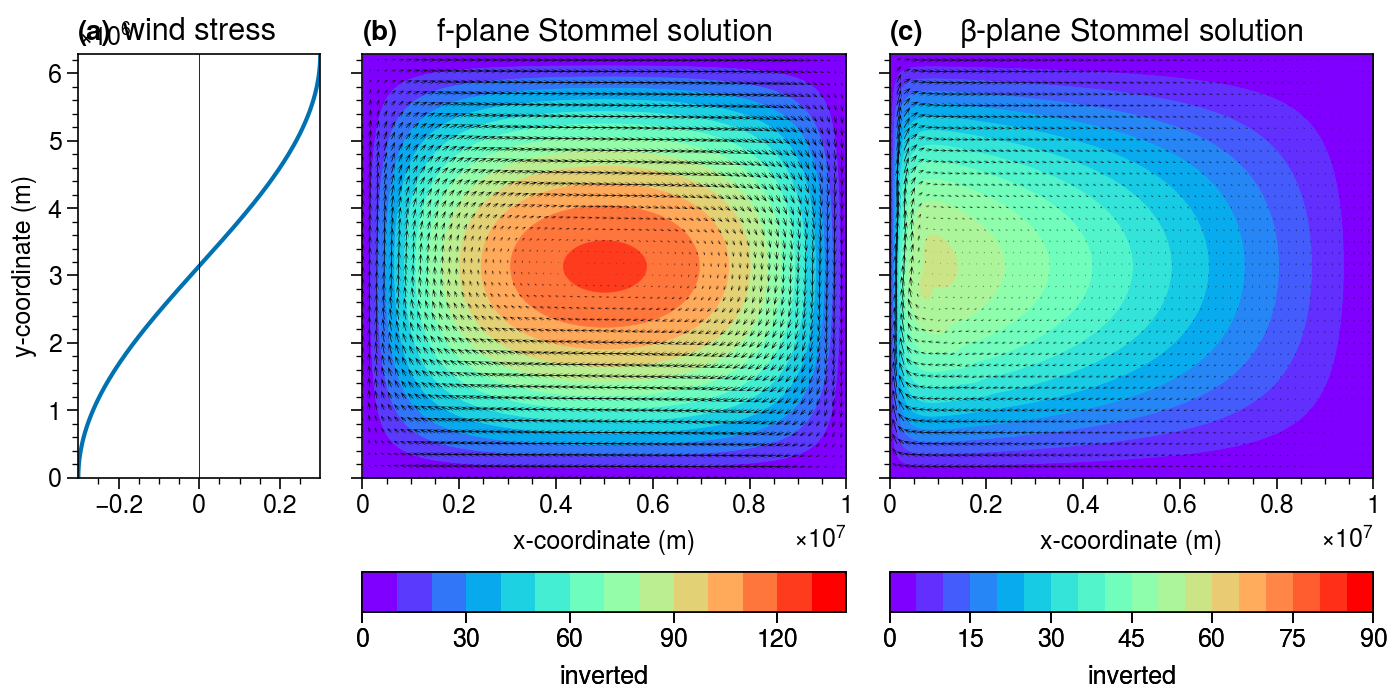

In [3]:
import proplot as pplt

array = [
    [1, 2, 2, 3, 3,],
]

fig, axes = pplt.subplots(array, figsize=(7,3.5), sharex=0, sharey=3)

skip = 3
fontsize = 11

ax = axes[0]
ax.plot(tau_ideal[:,0], tau_ideal.ydef)
ax.plot(tau_ideal[:,0]-tau_ideal[:,0], tau_ideal.ydef, color='k', linewidth=0.3)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)
ax.set_title('wind stress', fontsize=fontsize)

ax = axes[1]
m=ax.contourf(S1/1e6*depth, cmap='rainbow', levels=np.linspace(0, 140, 15))
ax.set_title('$f$-plane Stommel solution', fontsize=fontsize)
p=ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u1.values[::skip+1,::skip], v1.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=10)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

ax = axes[2]
m=ax.contourf(S2/1e6*depth, cmap='rainbow', levels=np.linspace(0, 90, 19))
ax.set_title('$\\beta$-plane Stommel solution', fontsize=fontsize)
ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u2.values[::skip+1,::skip], v2.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=8)
              # headwidth=1, headlength=3, width=0.002)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

axes.format(abc='(a)', grid=False, ylabel='y-coordinate (m)')

It is clear that on the $\beta$-plane there is an intensification of the circulation.

### 3.2 The classical Munk example
[**Munk (1950)**](https://journals.ametsoc.org/view/journals/atsc/7/2/1520-0469_1950_007_0080_otwdoc_2_0_co_2.xml) modified Stommel's model by adding a lateral diffusion term and dropping the bottom linear-drag friction.  We are going to reproduce the above example using Munk model by adding a biharmonic coefficient `AH` and setting the bottom linear drag coefficient `R` to zero.  This is as simple as:

In [4]:
from xinvert import invert_StommelMunk, cal_flow

iParams = {
    'BCs'      : ['fixed', 'fixed'],
    'mxLoop'   : 4000,
    'tolerance': 1e-8,
    'optArg'   : 1.0,
}

mParams1 = {'R': 0, 'D': depth, 'A4':1e4, 'beta':0}
mParams2 = {'R': 0, 'D': depth, 'A4':1e4, 'beta':beta}

h1 = invert_StommelMunk(curl_tau, dims=['ydef','xdef'], coords='cartesian', mParams=mParams1, iParams=iParams)
h2 = invert_StommelMunk(curl_tau, dims=['ydef','xdef'], coords='cartesian', mParams=mParams2, iParams=iParams)

u1, v1 = cal_flow(h1, dims=['ydef','xdef'], coords='cartesian')
u2, v2 = cal_flow(h2, dims=['ydef','xdef'], coords='cartesian')

{} loops 4000 and tolerance is 2.448634e-04
{} loops 4000 and tolerance is 1.657930e-04


Results can be plotted as:

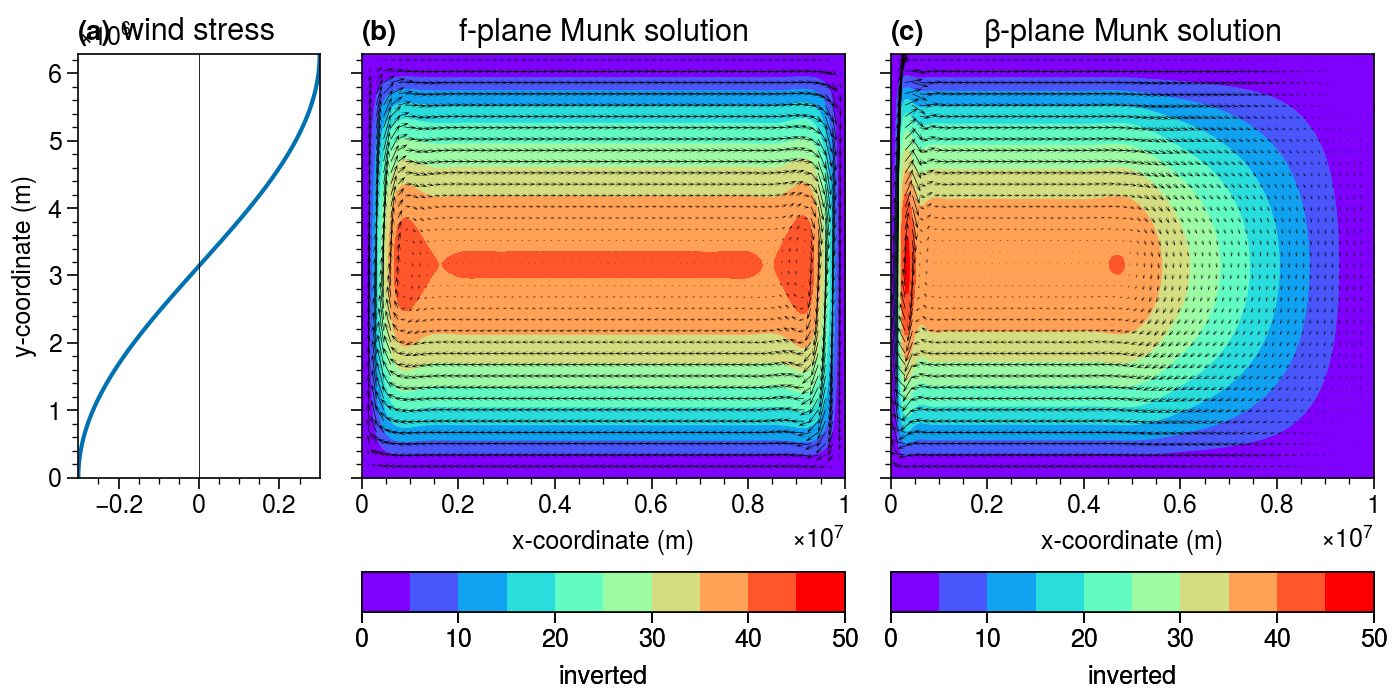

In [9]:
array = [[1, 2, 2, 3, 3,],]

fig, axes = pplt.subplots(array, figsize=(7,3.5), sharex=0, sharey=3)

skip = 3
fontsize = 11

ax = axes[0]
ax.plot(tau_ideal[:,0], tau_ideal.ydef)
ax.plot(tau_ideal[:,0]-tau_ideal[:,0], tau_ideal.ydef, color='k', linewidth=0.3)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)
ax.set_title('wind stress', fontsize=fontsize)

ax = axes[1]
m=ax.contourf(h1/1e6*depth, cmap='rainbow', levels=np.linspace(0, 50, 11))
ax.set_title('$f$-plane Munk solution', fontsize=fontsize)
p=ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u1.values[::skip+1,::skip], v1.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=4)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

ax = axes[2]
m=ax.contourf(h2/1e6*depth, cmap='rainbow', levels=np.linspace(0, 50, 11))
ax.set_title('$\\beta$-plane Munk solution', fontsize=fontsize)
ax.quiver(xgrid.values[::skip+1,::skip], ygrid.values[::skip+1,::skip],
              u2.values[::skip+1,::skip], v2.values[::skip+1,::skip],
              width=0.0014, headwidth=8., headlength=12., scale=4)
              # headwidth=1, headlength=3, width=0.002)
ax.colorbar(m, loc='b')
ax.set_ylim([0, Ly])
ax.set_xlim([0, Lx])
ax.set_xlabel('x-coordinate (m)', fontsize=fontsize-2)
ax.set_ylabel('y-coordinate (m)', fontsize=fontsize-2)

axes.format(abc='(a)', grid=False, ylabel='y-coordinate (m)')

The Munk layer at western part of the domain (panel c) is clear.

### 3.3 The realistic example using full Stommel-Munk model

Now we are moving onto a more realistic case: using the climatological wind stress and topography data to calculate the wind-driven circulation over the global ocean.  First loading the data:

In [10]:
#%% real cases
import xarray as xr

# load in wind stress from SODA product
ds = xr.open_dataset('../../../Data/SODA_curl.nc')
curl = ds.curl

Then invert using the Stommel-Munk model:

In [11]:
from xinvert import invert_StommelMunk, cal_flow

iParams = {
    'BCs'      : ['fixed', 'periodic'],
    'mxLoop'   : 4000,
    'tolerance': 1e-14,
    'optArg'   : 1.0,
    'undef'    : np.nan,
}

mParams = {'R': 1e-4, 'D': 100, 'A4':3e3, 'beta':beta, 'rho0':1027}

# inversion for streamfunction and flow vector
h1 = invert_StommelMunk(curl[0], dims=['lat','lon'], mParams=mParams, iParams=iParams)

u1, v1 = cal_flow(h1, dims=['lat','lon'], BCs=['extend','periodic'])

{} loops 4000 and tolerance is 5.033673e-05


Finally, plot the results:

C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


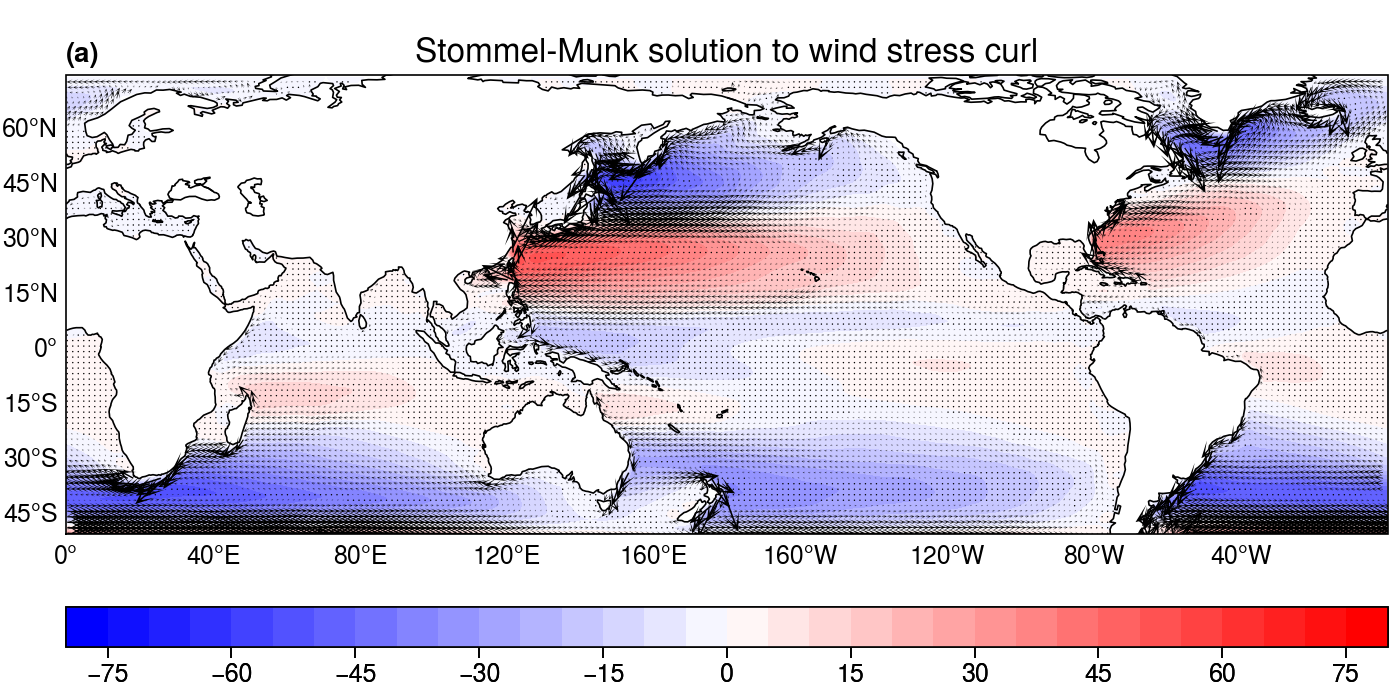

In [18]:
lat, lon = xr.broadcast(u1.lat, u1.lon)

fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(7, 3.5), sharex=3, sharey=3, proj=pplt.Proj('cyl', lon_0=180))

skip = 3
fontsize = 12

ax = axes[0]
p=ax.contourf(h1/1e6*100, cmap='bwr', levels=np.linspace(-80,80,33))
ax.set_title('Stommel-Munk solution to wind stress curl', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip], lat.values[::skip,::skip],
              u1.values[::skip,::skip], v1.values[::skip,::skip],
              width=0.0012, headwidth=10., headlength=12., scale=70)
ax.set_ylim([-50, 75])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='b', label='', ticks=15, length=1)

axes.format(abc='(a)', coast=True, lonlines=40, latlines=15, lonlabels='b', latlabels='l', grid=False, labels=False)

It is clear that much of the observed features are reproduced by the simple model, including the western boundary currents, double-gyre circulations, ACC etc.  We enlarge the part over the western North Pacific for a clearer view:

C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


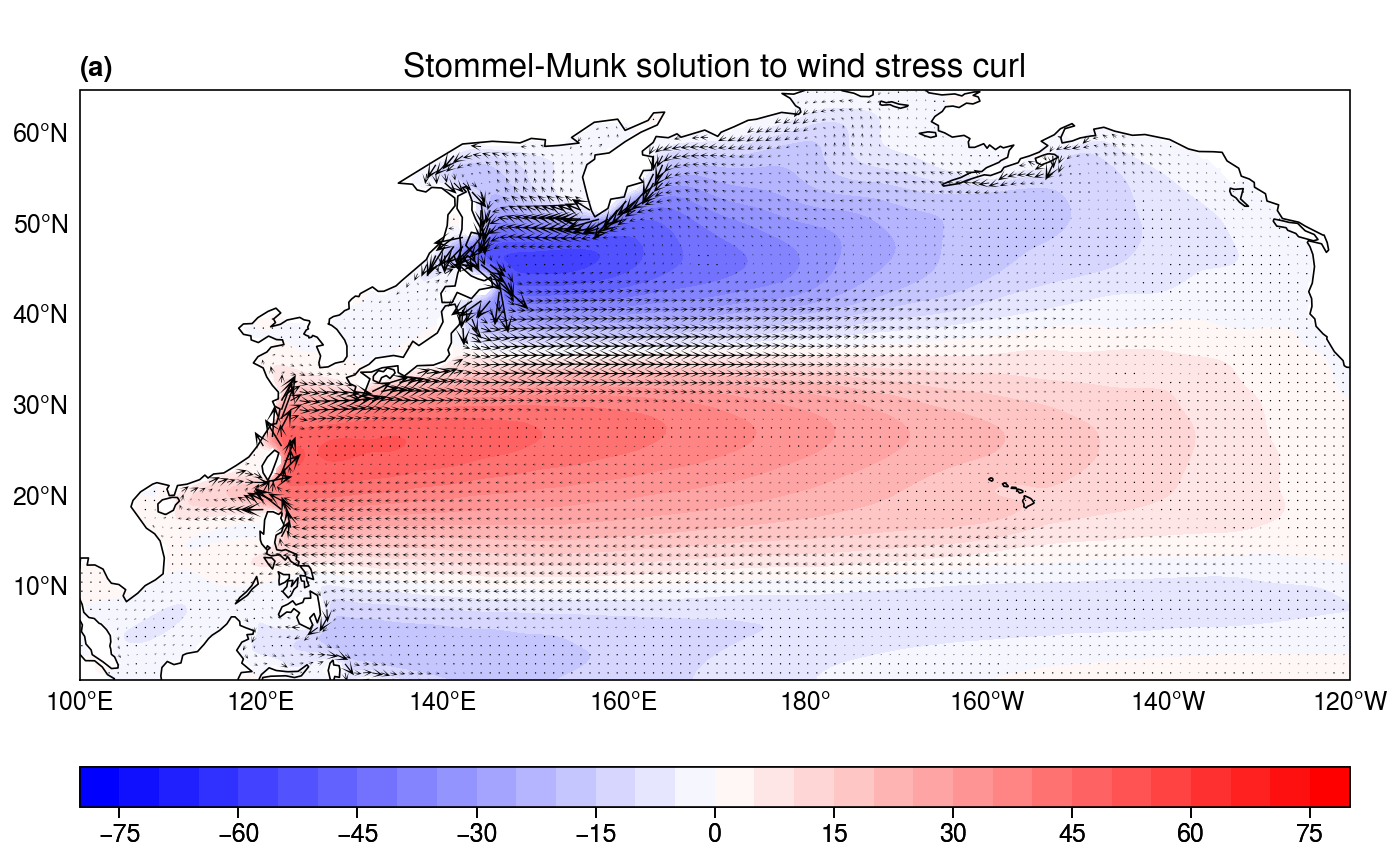

In [21]:
fig, axes = pplt.subplots(nrows=1, ncols=1, figsize=(7, 4.3), sharex=3, sharey=3, proj=pplt.Proj('cyl', lon_0=180))

skip = 2
fontsize = 12

ax = axes[0]
p=ax.contourf(h1/1e6*100, cmap='bwr', levels=np.linspace(-80,80,33))
ax.set_title('Stommel-Munk solution to wind stress curl', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip], lat.values[::skip,::skip],
              u1.values[::skip,::skip], v1.values[::skip,::skip],
              width=0.0012, headwidth=10., headlength=12., scale=80)
ax.set_ylim([-0, 65])
ax.set_xlim([-80, 60])
ax.colorbar(p, loc='b', label='', ticks=15, length=1)

axes.format(abc='(a)', coast=True, lonlines=20, latlines=10, lonlabels='b', latlabels='l', grid=False, labels=False)

We can also perform calculations using wind stress in different seasons, as well as spatial-varying bottom friction $R$ that is larger at higher latitudes (so that the ACC transport is reduced somewhat).

In [23]:
# loading climatological January
curl_Jan = curl[0].load()
# loading climatological July
curl_Jul = curl[6].load()

iParams = {
    'BCs'      : ['fixed', 'periodic'],
    'mxLoop'   : 4000,
    'tolerance': 1e-14,
    'optArg'   : 1.0,
    'undef'    : np.nan,
}

# use spatial-varying bottom friction
mParams = {'R':2e-4 * (2 - 1*np.cos(np.deg2rad(lat))), 'rho0':1027, 'A4':3e3, 'beta':beta, 'D':depth}

# inversion
h1 = invert_StommelMunk(curl_Jan, dims=['lat','lon'], mParams=mParams, iParams=iParams)
h2 = invert_StommelMunk(curl_Jul, dims=['lat','lon'], mParams=mParams, iParams=iParams)

u1, v1 = cal_flow(h1, dims=['lat','lon'], BCs=['extend','periodic'])
u2, v2 = cal_flow(h2, dims=['lat','lon'], BCs=['extend','periodic'])

{} loops 4000 and tolerance is 3.752573e-05
{} loops 4000 and tolerance is 5.311678e-05


Comparing the wind-driven patterns in different seasons:

C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
C:\ProgramData\anaconda3\lib\site-packages\cartopy\mpl\geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


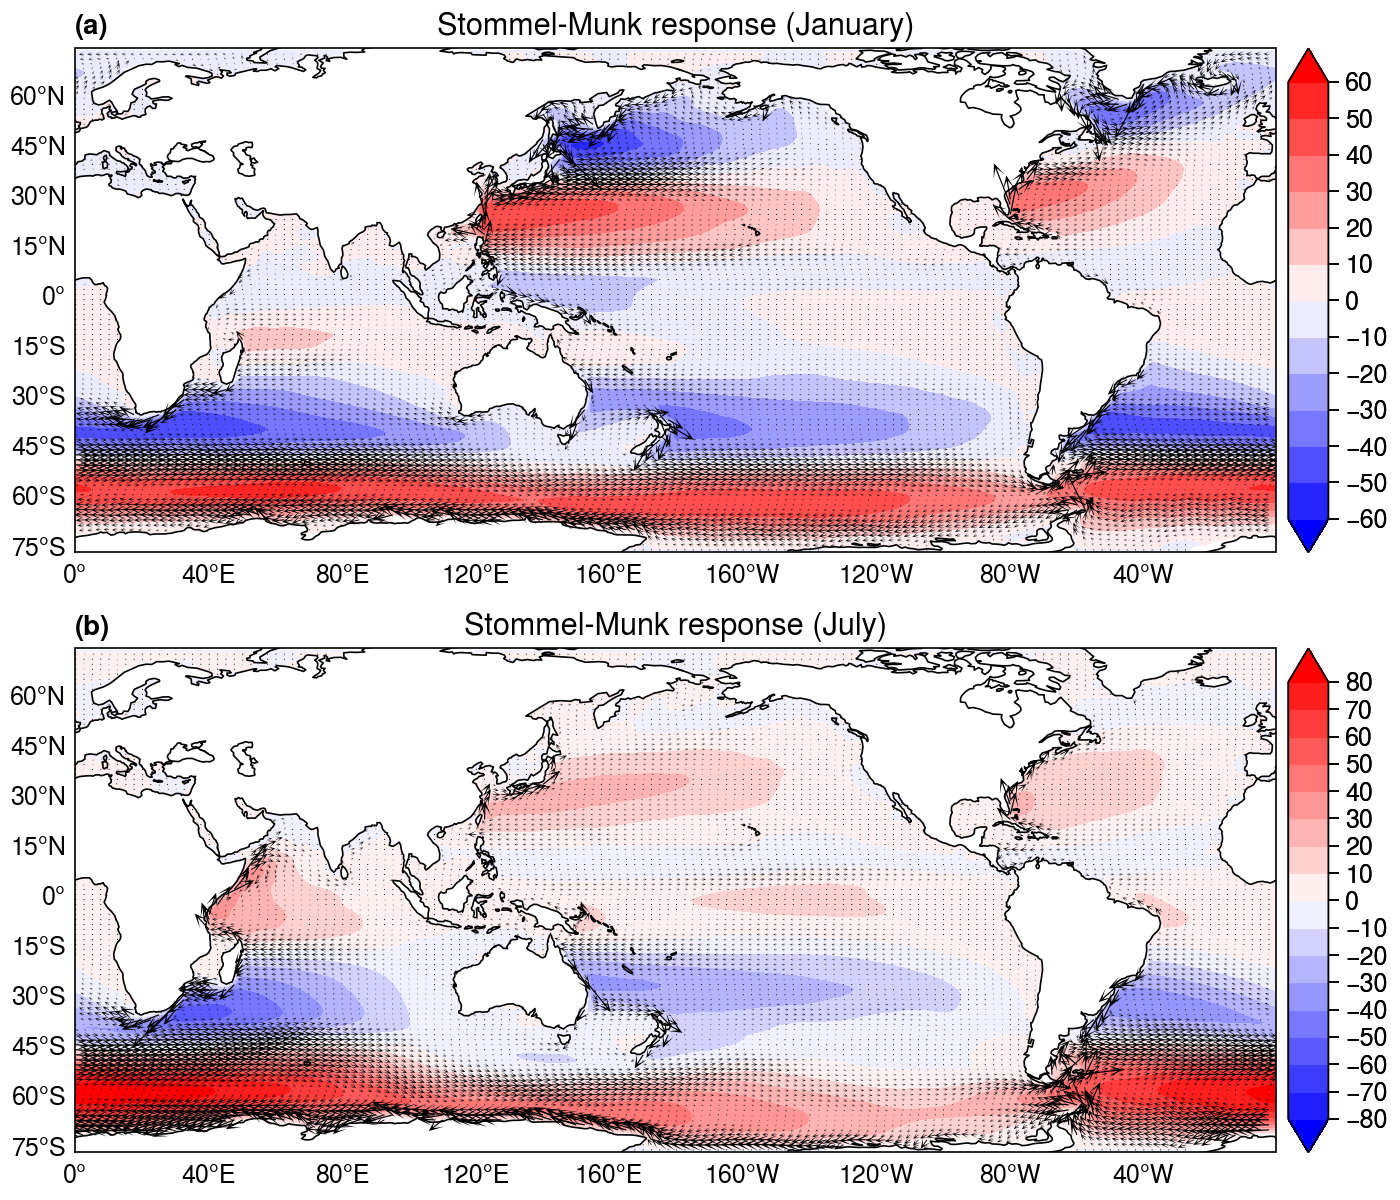

In [26]:
lat, lon = xr.broadcast(u1.lat, u1.lon)

fig, axes = pplt.subplots(nrows=2, ncols=1, figsize=(7, 6), sharex=3, sharey=3, proj=pplt.Proj('cyl', lon_0=180))

skip = 3
fontsize = 11

ax = axes[0,0]
p=ax.contourf(h1/1e6*depth, cmap='bwr', levels=np.linspace(-60,60,13), extend='both')
ax.set_title('Stommel-Munk response (January)', fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+2], lat.values[::skip,::skip+2],
           u1.values[::skip,::skip+2],  v1.values[::skip,::skip+2],
           width=0.001, headwidth=10., headlength=12., scale=30)
ax.set_ylim([-76, 75])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', label='', ticks=10)

ax = axes[1,0]
p=ax.contourf(h2/1e6*depth, cmap='bwr', levels=np.linspace(-80,80,17), extend='both')
ax.set_title('Stommel-Munk response (July)',
             fontsize=fontsize)
ax.quiver(lon.values[::skip,::skip+2], lat.values[::skip,::skip+2],
           u2.values[::skip,::skip+2], v2.values[::skip,::skip+2],
           width=0.001, headwidth=10., headlength=12., scale=30)
ax.set_ylim([-76, 75])
ax.set_xlim([-180, 180])
ax.colorbar(p, loc='r', label='', ticks=10)

axes.format(abc='(a)', coast=True, lonlines=40, latlines=15, lonlabels='b', latlabels='l', grid=False, labels=False)

Striking features are the weakening of the gyre circulation over the northern hemisphere in July and strengthening of the Somali jet over the Indian Ocean.

---

### References
1. Munk, W., 1950: [On the wind-driven ocean circulation.](https://journals.ametsoc.org/view/journals/atsc/7/2/1520-0469_1950_007_0080_otwdoc_2_0_co_2.xml) *Journal of Meteorology*, **7**, 79-93.
2. Stommel, H., 1948: [The westward intensification of wind‐driven ocean currents.](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/TR029i002p00202) *Eos, Transactions American Geophysical Union*, **29**, 202-206.